In [1]:
import imageio
import cv2
import numpy as np
import pickle
import re
from pathlib import Path
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
folder_path = Path("./jumpingjack")

In [3]:
vids = []
n_frames = []
fps = 50
H, W, C = 0, 0, 0

for file_path in folder_path.glob("*"):
    vid = imageio.get_reader(file_path, "ffmpeg", fps=fps)
    vids.append(vid)
    for i, frame in enumerate(vid):
        if i == 0:
            H, W, C = frame.shape
        pass
    n_frames.append(i)

n_frames = np.array(n_frames)
n_frames

array([209, 107, 205, 139, 101, 291, 111, 177, 109])

## First approach: Random but evenly spread frames

In [4]:
# We will extract 5 sequences of 10 frames from each of the 9 videos
# This algorithm randomly selects 10 frames from a video, ensuring
# that the 10 frames are roughly evenly spread across the full video
frame_numbers = np.zeros((45, 10))
np.random.seed(42)

for i, length in enumerate(n_frames):
    for vid_num in range(5):
        frames = np.zeros(10)
        for frame_num in range(10):
            prev_frame_num = frames[frame_num-1] if frame_num != 0 else 0
            interval = (length - prev_frame_num) // (10 - frame_num)
            rand_int = np.random.randint(low=3, high=interval, size=1)
            rand_int = rand_int if prev_frame_num + rand_int < length else length
            frames[frame_num] = prev_frame_num + rand_int
        
        frame_numbers[5*i + vid_num] = frames

In [5]:
# Save the RGB frames in a numpy array
to_save = np.zeros((45, 10, 144, 180, 3), dtype='uint8')

for vid_num, vid in enumerate(vids):
    for frame_num, frame in enumerate(vid):
        positions = np.where(frame_numbers[vid_num*5:(vid_num*5 + 5)] == frame_num)
        to_save[vid_num*5:(vid_num*5 + 5)][positions] = frame

[24]


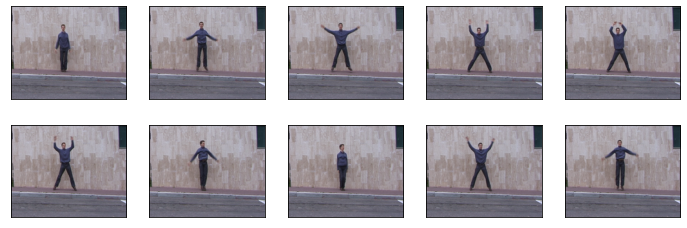

In [6]:
# Check a sequence
id = np.random.randint(low=0, high=44, size=1)
print(id)
fig, ax = plt.subplots(2, 5, figsize=(12, 4))
for i, frame in enumerate(to_save[int(id)]):
    ax[i//5, i%5].imshow(frame)
    ax[i//5, i%5].set_xticks([])
    ax[i//5, i%5].set_yticks([])

### Save as numpy array

In [7]:
# np.save("jumpingjack2.npy", to_save)

## Second approach: Fixed intervals

In [8]:
n_frames

array([209, 107, 205, 139, 101, 291, 111, 177, 109])

In [9]:
# Save the RGB frames in a numpy array
interval = 3
frames_per_seq = 10
seqs_per_vid = np.array(n_frames, dtype='uint') // (interval * frames_per_seq)
total_num_vids = np.sum(seqs_per_vid)
print(f"Total number of sequences: {total_num_vids}")
to_save = np.zeros((total_num_vids, frames_per_seq, H, W, C), dtype='uint8')

seq_num = 0
frame_pos = 0

for vid_num, vid in enumerate(vids):
    for frame_num, frame in enumerate(vid):
        last_frame = int(seqs_per_vid[vid_num] * (interval * frames_per_seq))
        if frame_num in range(0, last_frame, interval):
            to_save[seq_num, frame_pos] = frame 
            frame_pos += 1
            if frame_pos == 10:
                seq_num += 1
                frame_pos = 0

Total number of sequences: 42


In [10]:
# Offset by 2 frames and repeat
offset = 3
n_frames_offset = n_frames - offset
interval = 3
frames_per_seq = 10
seqs_per_vid = np.array(n_frames, dtype='uint') // (interval * frames_per_seq)
total_num_vids = np.sum(seqs_per_vid)
print(f"Total number of sequences: {total_num_vids}")
to_save_2 = np.zeros((total_num_vids, frames_per_seq, H, W, C), dtype='uint8')

seq_num = 0
frame_pos = 0

for vid_num, vid in enumerate(vids):
    for frame_num, frame in enumerate(vid):
        last_frame = int(seqs_per_vid[vid_num] * (interval * frames_per_seq))
        if frame_num in range(offset, last_frame+offset, interval):
            to_save_2[seq_num, frame_pos] = frame 
            frame_pos += 1
            if frame_pos == 10:
                seq_num += 1
                frame_pos = 0

Total number of sequences: 42


id: 39


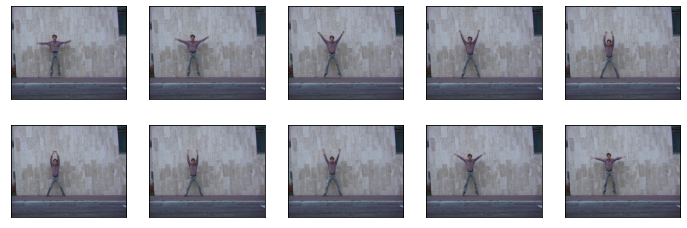

In [11]:
# Check a sequence
id = np.random.randint(total_num_vids)
print(f"id: {id}")
fig, ax = plt.subplots(2, 5, figsize=(12, 4))
for i, frame in enumerate(to_save[int(id)]):
    ax[i//5, i%5].imshow(frame)
    ax[i//5, i%5].set_xticks([])
    ax[i//5, i%5].set_yticks([])

id: 39


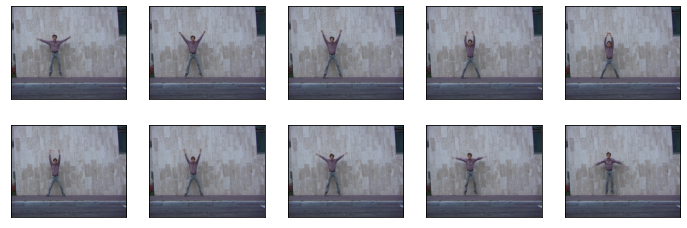

In [12]:
# Check a sequence
print(f"id: {id}")
fig, ax = plt.subplots(2, 5, figsize=(12, 4))
for i, frame in enumerate(to_save_2[int(id)]):
    ax[i//5, i%5].imshow(frame)
    ax[i//5, i%5].set_xticks([])
    ax[i//5, i%5].set_yticks([])

### Save as numpy array

In [13]:
combined = np.concatenate([to_save, to_save_2], axis=0)
np.save("jumpingjack.npy", combined)